In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for figures
%matplotlib inline

In [2]:
words = open('names.txt').read().splitlines()
print(f"Lenth: {len(words)} | Data Sample: {words[:4]}")

Lenth: 32033 | Data Sample: ['emma', 'olivia', 'ava', 'isabella']


In [ ]:
words = open('names.txt').read().splitlines()
print(f"Lenth: {len(words)} | Data Sample: {words[:4]}")

# Build vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos.keys())

# Build dataset
BLOCK_SIZE = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:

        context = [0] * BLOCK_SIZE
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # %80
Xdev, Ydev = build_dataset(words[n1:n2]) # %10
Xte, Yte = build_dataset(words[n2:]) # %10

In [3]:
# Build vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos.keys())

In [4]:
BLOCK_SIZE = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:

        context = [0] * BLOCK_SIZE
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # %80
Xdev, Ydev = build_dataset(words[n1:n2]) # %10
Xte, Yte = build_dataset(words[n2:]) # %10

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


#### Build the NN

In [5]:
# --------------------- Set Params --------------------- #
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
# used for kaimin init
gain = 5/3 
fan_in = n_embd * BLOCK_SIZE
# --------------------- Build the NN --------------------- #
g = torch.Generator().manual_seed(2147483647) # for reporducability
C = torch.randn((vocab_size, n_embd),           generator=g) # nn space for char enc
W1 = torch.randn((n_embd*BLOCK_SIZE, n_hidden), generator=g) * (gain / (fan_in**0.5))
# b1 = torch.randn(n_hidden,                      generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2 = torch.randn(vocab_size,                    generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbais = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

params = [C, W1, b1, W2, b2, bngain, bnbais]
print(f"Total Params: {sum(p.nelement() for p in params)}")
for p in params:
    p.requires_grad = True # set gradients for tracking

NameError: name 'b1' is not defined

#### Train the NN

In [ ]:
# ----------------------- Set Vars ----------------------- #
max_steps = 200_000
batch_size = 32 
lr1, lr2 = 0.1, 0.01
lossi = []

# ----------------------- Train ----------------------- #
for i in range(max_steps):
    # Construct mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X, Y

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # "concat" vectors
    # Linear layer
    hpreact = embcat @ W1 # + b1 | are being subtracted out w/ bnmean subtraction
    # Normalize hpreact w/ scale and shift
    # BatchNorm Layer
    # -------------------------------------------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbais # bnbais is "in charge of biasing distribution"
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------------------------------------------
    # Non-linearity 
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # update
    lr = lr1 if i < 100_000 else lr2  # learning rate decay
    for p in params:
        p.data += -lr * p.grad

    # Stats
    if i % 10000 == 0: # print every so often
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # break

      0/ 200000: 3.3222
  10000/ 200000: 2.4799
  20000/ 200000: 1.8152
  30000/ 200000: 2.4790
  40000/ 200000: 2.6265
  50000/ 200000: 2.2572
  60000/ 200000: 1.8586
  70000/ 200000: 2.0966
  80000/ 200000: 2.0972
  90000/ 200000: 2.0101
 100000/ 200000: 2.2562
 110000/ 200000: 1.8282
 120000/ 200000: 2.5602
 130000/ 200000: 2.0930
 140000/ 200000: 1.7700
 150000/ 200000: 1.8840
 160000/ 200000: 2.1893
 170000/ 200000: 2.4190
 180000/ 200000: 2.2026
 190000/ 200000: 2.0786


The deeper your network the more the initial errors become problematic for training

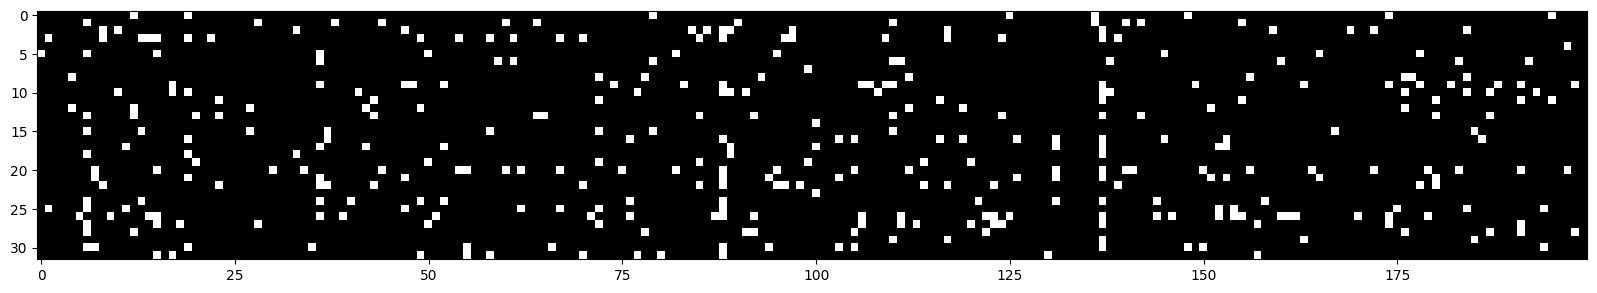

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') # white is inactive 

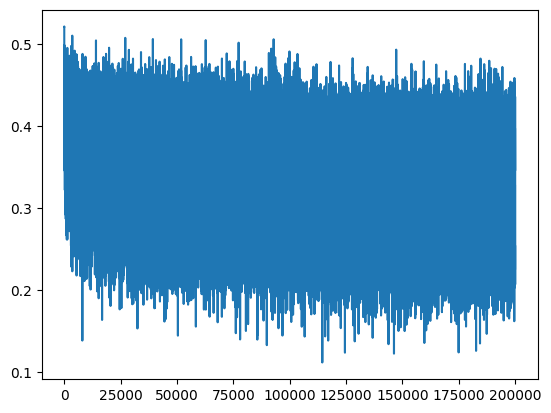

In [ ]:
plt.plot(lossi)

#### Evaluate the NN

In [ ]:
@torch.no_grad() # disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # (N, block_size*n_embd)
    hpreact = embcat @ W1 + b1
    #hpreact = bngain * ((hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)) + bnbais
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbais
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.066805601119995
val 2.1059858798980713


#### Sample the NN

In [ ]:
g = torch.Generator().manual_seed(125)

for _ in range(10):
    out = []
    context = [0] * BLOCK_SIZE # initialize with all...
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0: break

    print(''.join(itos[i] for i in out))

japhtln.
kdskmatzi.
suph.
katrjubaylennithlinnckeng.
shaannahmaelyaeybh.
brsehmnyettreykhhrajobruthl.
grregakrysschtln.
madzlynn.
klysttrr.
prackingrakshev.
